In [2]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation as cv
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn import preprocessing
from scipy.stats import randint as sp_randint
import pydot
import StringIO

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#Load demographic and behavioral features 
client_features = pd.read_csv("clientes_unicos.csv", sep=",", 
usecols= ['document_number','gender', 'fqtv_data', 'advance_purchase','age', 'cabin_code', 'distance_seg', 'pos_channel_code', 'flight_type'])

In [4]:
client_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523541 entries, 0 to 523540
Data columns (total 9 columns):
gender              523541 non-null object
age                 523541 non-null int64
document_number     523541 non-null object
fqtv_data           523541 non-null object
cabin_code          523541 non-null object
advance_purchase    523541 non-null int64
pos_channel_code    507645 non-null object
distance_seg        523541 non-null float64
flight_type         523541 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 35.9+ MB


In [5]:
rfm_clustered = pd.read_csv("rfm_with_clusters.csv", sep=",", usecols=[1,2,3,4,5])

In [6]:
rfm_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175333 entries, 0 to 175332
Data columns (total 5 columns):
document_number    175333 non-null object
frecuency          175333 non-null int64
recency            175333 non-null int64
money              175333 non-null float64
cluster            175333 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 6.7+ MB


# Process personal and behavioral data

In [8]:
def Economy(cabin_code):
    if cabin_code == 'Y':
        return 'Economy'
    elif cabin_code == 'J':
        return 'Business'
    else:
        return 'Premium'

In [9]:
def Loyalty(fqtv_data):
    if fqtv_data == " ":
        return 0
    else:
        return 1

In [10]:
def Channel(creator_channel):
    if creator_channel == "E":
        return 'Electronic'
    elif creator_channel == "A":
        return 'Airline'
    elif creator_channel == "T":
        return 'Travel_Agency'
    else:
        return 'No-Iata'

In [11]:
client_features['cabin_code'] = client_features.cabin_code.apply(Economy)
client_features['fqtv_data'] = client_features.fqtv_data.apply(Loyalty)
client_features['pos_channel_code'] = client_features.pos_channel_code.apply(Channel)
client_features.head(10)

,gender,age,document_number,fqtv_data,cabin_code,advance_purchase,pos_channel_code,distance_seg,flight_type
0,M,61,000744336,1,Economy,8,Travel_Agency,1864.409218,I
1,M,61,000744336,1,Economy,9,Travel_Agency,1864.409218,I
2,M,49,00152Y444,1,Economy,12,Travel_Agency,691.510048,I
3,M,49,00152Y444,1,Economy,2,Travel_Agency,691.510048,I
4,F,75,002946569,1,Economy,55,Electronic,392.978958,I
5,F,75,002946569,1,Economy,37,Electronic,392.978958,I
6,F,75,002946569,1,Economy,55,Electronic,6610.159533,I
7,F,75,002946569,1,Economy,36,Electronic,6610.159533,I
8,M,62,00453BS41,1,Economy,55,No-Iata,7894.805996,I
9,M,56,00517BF34,1,Economy,220,Travel_Agency,7894.805996,I


In [12]:
# Merge personal and behavioral features and RFM variables based on document number as primary key
All_features = pd.merge(client_features, rfm_clustered, on = 'document_number')

In [14]:
All_features.head(20)

,gender,age,document_number,fqtv_data,cabin_code,advance_purchase,pos_channel_code,distance_seg,flight_type,frecuency,recency,money,cluster
0,M,61,000744336,1,Economy,8,Travel_Agency,1864.409218,I,1,28,221.26,0
1,M,61,000744336,1,Economy,9,Travel_Agency,1864.409218,I,1,28,221.26,0
2,M,49,00152Y444,1,Economy,12,Travel_Agency,691.510048,I,1,171,205.00,2
3,M,49,00152Y444,1,Economy,2,Travel_Agency,691.510048,I,1,171,205.00,2
4,F,75,002946569,1,Economy,55,Electronic,392.978958,I,1,282,291.68,2
5,F,75,002946569,1,Economy,37,Electronic,392.978958,I,1,282,291.68,2
6,F,75,002946569,1,Economy,55,Electronic,6610.159533,I,1,282,291.68,2
7,F,75,002946569,1,Economy,36,Electronic,6610.159533,I,1,282,291.68,2
8,M,62,00453BS41,1,Economy,55,No-Iata,7894.805996,I,1,22,250.51,0
9,M,56,00517BF34,1,Economy,220,Travel_Agency,7894.805996,I,1,32,313.00,0


# Data visualization

### We will analyze the relationship between cluster classification and client features


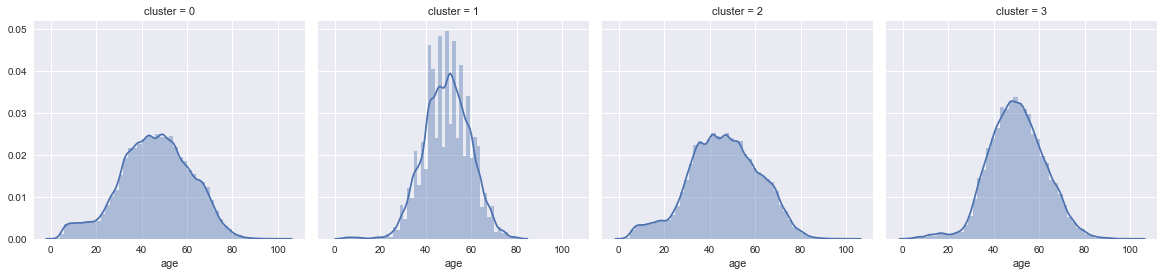

In [15]:
#Age distribution per Cluster
g= sns.FacetGrid(All_features, col="cluster", col_wrap=10, size=4)
g.map(sns.distplot,"age" )

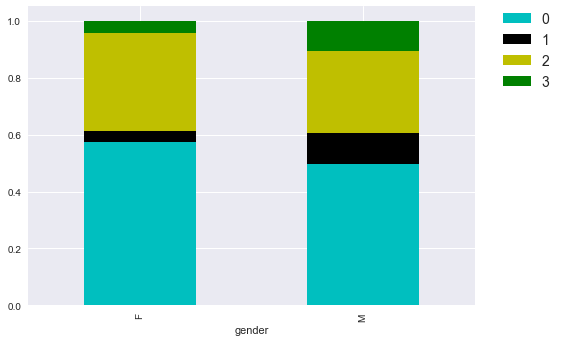

In [16]:
#Gender distribution per Cluster
a=All_features.groupby('gender').cluster.value_counts()/All_features.groupby('gender').cluster.count()
a.unstack().plot(kind='bar',stacked=True,color=['c','k', 'y', 'g'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=14)

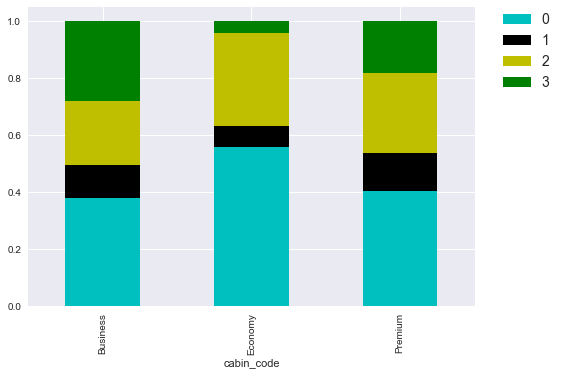

In [17]:
#Costumer type distribution per Cluster
a=All_features.groupby('cabin_code').cluster.value_counts()/All_features.groupby('cabin_code').cluster.count()
a.unstack().plot(kind='bar',stacked=True,color=['c','k', 'y', 'g'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=14)

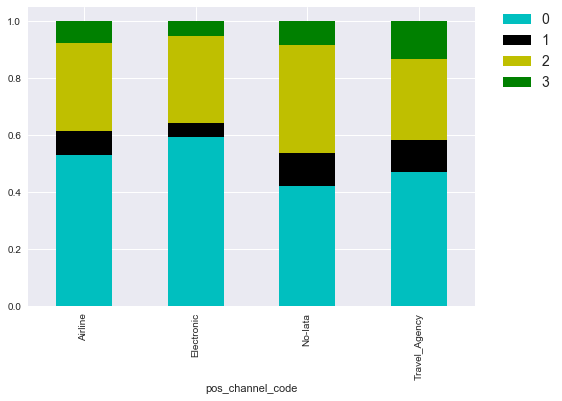

In [18]:
#Booking channel distribution per Cluster
a=All_features.groupby('pos_channel_code').cluster.value_counts()/All_features.groupby('pos_channel_code').cluster.count()
a.unstack().plot(kind='bar',stacked=True,color=['c','k', 'y', 'g'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=14)

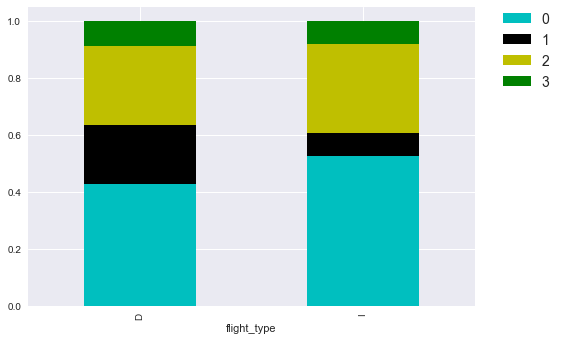

In [19]:
#Flight type distribution per Cluster
a=All_features.groupby('flight_type').cluster.value_counts()/All_features.groupby('flight_type').cluster.count()
a.unstack().plot(kind='bar',stacked=True,color=['c','k', 'y', 'g'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=14)

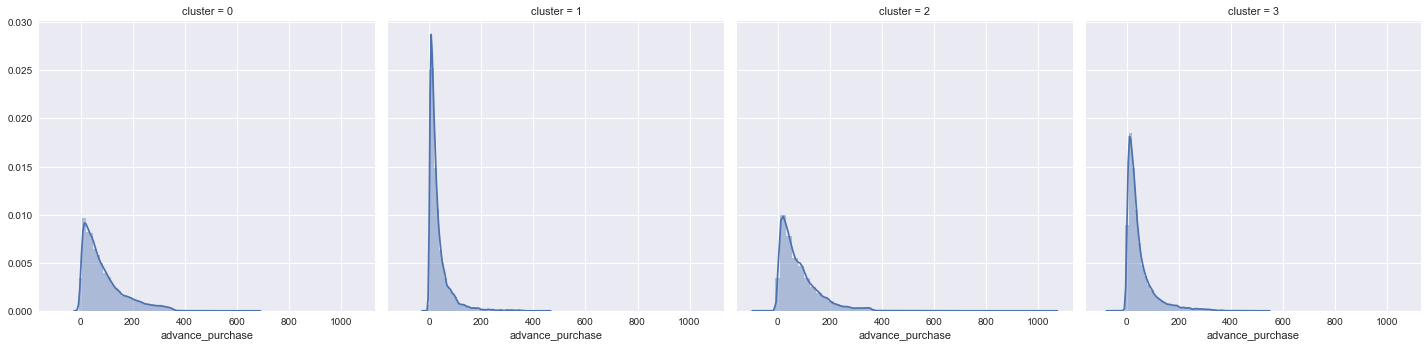

In [20]:
#Advanced purchase distribution per Cluster
g= sns.FacetGrid(All_features, col="cluster", col_wrap=4, size=5)
g.map(sns.distplot,"advance_purchase")

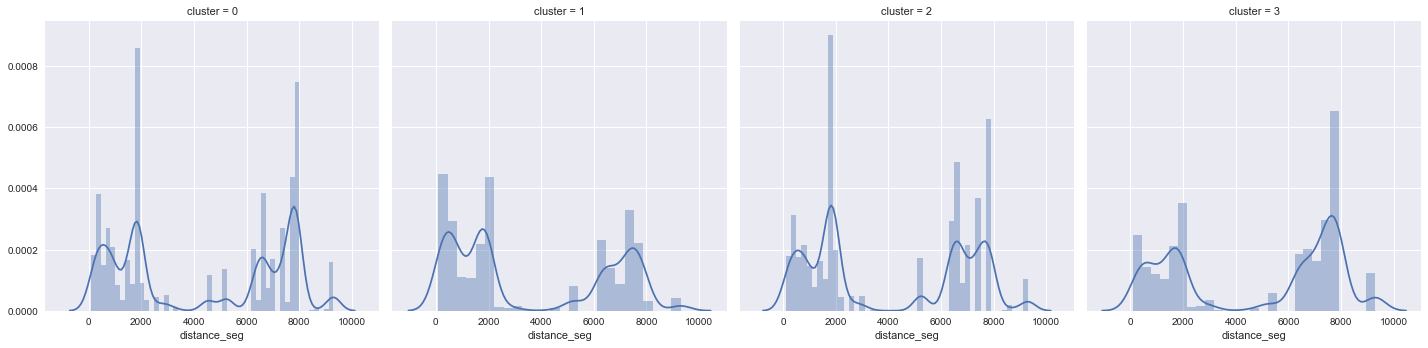

In [21]:
#Distance distribution per Cluster
g= sns.FacetGrid(All_features, col="cluster", col_wrap=4, size=5)
g.map(sns.distplot,"distance_seg" )

# Feature engineering

In [22]:
# We will use dummy variables to transform categorical variables
dummies_Gender=pd.get_dummies(client_features['gender'],prefix='Sex')
dummies_Pclass=pd.get_dummies(client_features['cabin_code'],prefix='Pclass')
dummies_channel = pd.get_dummies(client_features.pos_channel_code, prefix= 'Channel')
dummies_flight= pd.get_dummies(client_features.flight_type, prefix = "Flight")
client_features = pd.concat([client_features, dummies_Gender, dummies_Pclass, dummies_channel, dummies_flight], axis=1)
client_features = client_features.drop(['gender','cabin_code','pos_channel_code','flight_type'], axis=1)
client_features.head()

,age,document_number,fqtv_data,advance_purchase,distance_seg,Sex_F,Sex_M,Pclass_Business,Pclass_Economy,Pclass_Premium,Channel_Airline,Channel_Electronic,Channel_No-Iata,Channel_Travel_Agency,Flight_D,Flight_I
0,61,000744336,1,8,1864.409218,0,1,0,1,0,0,0,0,1,0,1
1,61,000744336,1,9,1864.409218,0,1,0,1,0,0,0,0,1,0,1
2,49,00152Y444,1,12,691.510048,0,1,0,1,0,0,0,0,1,0,1
3,49,00152Y444,1,2,691.510048,0,1,0,1,0,0,0,0,1,0,1
4,75,002946569,1,55,392.978958,1,0,0,1,0,0,1,0,0,0,1


In [23]:
client_features.count()

age                      523541
document_number          523541
fqtv_data                523541
advance_purchase         523541
distance_seg             523541
Sex_F                    523541
Sex_M                    523541
Pclass_Business          523541
Pclass_Economy           523541
Pclass_Premium           523541
Channel_Airline          523541
Channel_Electronic       523541
Channel_No-Iata          523541
Channel_Travel_Agency    523541
Flight_D                 523541
Flight_I                 523541
dtype: int64

In [24]:
rfm_clustered.count()

document_number    175333
frecuency          175333
recency            175333
money              175333
cluster            175333
dtype: int64

In order to have the same number of rows in client_features (523.541) and rfm_clustered (175.333) data frames we have to group each sample of the client feature dataframe by document_number and then aggregate the variables to have just one row per passenger

In [25]:
client_features = client_features.groupby(['document_number']).agg({ 'age': lambda x: x.mean(),
                                            'advance_purchase': lambda x: x.mean(),
                                            'distance_seg': lambda x: x.mean(),          
                                            'Sex_F': lambda x: x.max(),
                                            'Sex_M': lambda x: x.max(),
                                            'Pclass_Business': lambda x: x.max(),
                                            'Pclass_Economy': lambda x: x.max(),
                                            'Pclass_Premium': lambda x: x.max(),         
                                            'Channel_Airline': lambda x: x.max(),
                                            'Channel_Electronic': lambda x: x.max(),         
                                            'Channel_No-Iata': lambda x: x.max(),          
                                            'Channel_Travel_Agency': lambda x: x.max(),         
                                            'Flight_D': lambda x: x.max(),        
                                            'Flight_I': lambda x: x.max(),       
                                            'fqtv_data': lambda x: x.max()})

In [26]:
len(client_features)

175333

In [27]:
# We set document number as index
rfm_clustered.groupby(['document_number'])
rfm_clustered = rfm_clustered.set_index("document_number")

In [28]:
# We join both data frames using document number as primary key
df_clients = pd.concat([client_features, rfm_clustered], axis=1, join='outer', join_axes=[rfm_clustered.index], ignore_index=False,
       keys=None, levels=None, names=None, verify_integrity=False)

In [29]:
df_clients.head()

,Channel_No-Iata,distance_seg,Pclass_Business,Channel_Electronic,Channel_Travel_Agency,Sex_F,Channel_Airline,Sex_M,fqtv_data,Flight_D,age,Pclass_Economy,Pclass_Premium,advance_purchase,Flight_I,frecuency,recency,money,cluster
document_number,,,,,,,,,,,,,,,,,,,
000744336,0,1864.409218,0,0,1,0,0,1,1,0,61,1,0,8.50,1,1,28,221.26,0
00152Y444,0,691.510048,0,0,1,0,0,1,1,0,49,1,0,7.00,1,1,171,205.00,2
002946569,0,3501.569245,0,1,0,1,0,0,1,0,75,1,0,45.75,1,1,282,291.68,2
00453BS41,1,7894.805996,0,0,0,0,0,1,1,0,62,1,0,55.00,1,1,22,250.51,0
00517BF34,0,7894.805996,0,0,1,0,0,1,1,0,56,1,0,227.00,1,1,32,313.00,0


In [30]:
len(df_clients)

175333


# Selecting features

In this section we will select both independent and dependent variables. We will split the dataset in training and test and we will scale the independent variables

In [31]:
features = [ 'age', 'fqtv_data', 'advance_purchase', 'distance_seg', 'Sex_F', 'Sex_M', 'Pclass_Business', 'Flight_I', 'Flight_D', 'Pclass_Economy', 'Pclass_Premium', 'Channel_Airline', 'Channel_Electronic', 'Channel_No-Iata', 'Channel_Travel_Agency']


In [34]:
def samples(l):
    if l < 401:
        return 1
    elif 400<l<701:
        return 2
    else:
        return 3

In [35]:
df_clients['cluster'] = df_clients['money'].map(samples)

In [36]:
variables = df_clients[features]
X = sklearn.preprocessing.normalize(variables, norm='l2', axis=0, copy=True)
y = df_clients.cluster
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44)

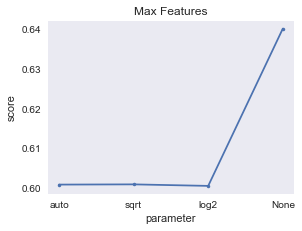

In [37]:
plt.figure(figsize=(15,7))

#Max Features
plt.subplot(2,3,1)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(scores, '.-')
plt.axis('tight')
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

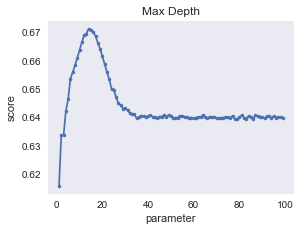

In [38]:
plt.figure(figsize=(15,7))

#Max Depth
plt.subplot(2,3,2)
feature_param = range(1,100)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

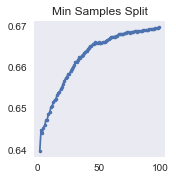

In [57]:
#Min Samples Split
plt.subplot(2,3,3)
feature_param = range(2,100)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Min Samples Split')
plt.grid();

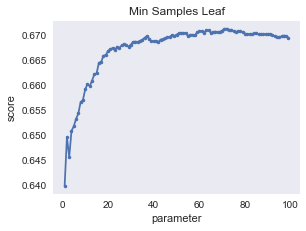

In [39]:
plt.figure(figsize=(15,7))

#Min Samples Leaf
plt.subplot(2,3,4)
feature_param = range(1,100)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('Min Samples Leaf')
plt.grid();

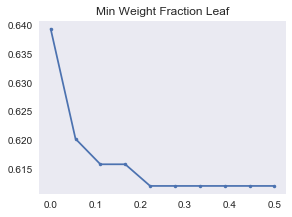

In [40]:
plt.figure(figsize=(15,7))

#Min Weight Fraction Leaf
plt.subplot(2,3,5)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

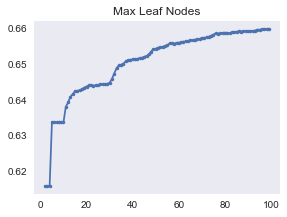

In [41]:
plt.figure(figsize=(15,7))

#Max Leaf Nodes
plt.subplot(2,3,6)
feature_param = range(2,100)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();

In [42]:
from sklearn.externals.six import StringIO  
import pydot
from sklearn import tree
from IPython.display import Image  

ctr = tree.DecisionTreeClassifier(criterion='gini', 
                             max_depth=20, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features=None, 
                             max_leaf_nodes=10, 
                             class_weight=None)

ctr_ = ctr.fit(X_train, y_train)

### We will check the performance of the Decision Tree model using the confusion matrix
The confusion matrix evaluates the quality of the classifier used, the Decision Tree model, based on the dataset given

[[ 0.98374628  0.          0.01625372]
 [ 0.96469105  0.          0.03530895]
 [ 0.83972734  0.          0.16027266]]


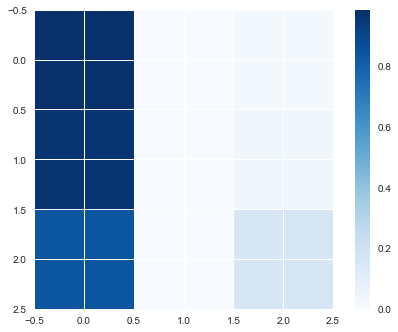

In [43]:
from sklearn.metrics import confusion_matrix
ctr_ = ctr.fit(X_train, y_train)
predictarr = ctr.predict(X_test)
trutharr = y_test.values
cm = confusion_matrix(trutharr, predictarr)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

confusion = np.matrix(cm_normalized)
print (cm_normalized)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

### We plot the feature importance resulting from Decision Tree Classifier


Feature ranking:
1. feature 6 (0.335495)
2. feature 3 (0.327951)
3. feature 2 (0.190943)
4. feature 12 (0.088846)
5. feature 9 (0.034452)
6. feature 11 (0.022313)
7. feature 14 (0.000000)
8. feature 13 (0.000000)
9. feature 10 (0.000000)
10. feature 8 (0.000000)
11. feature 7 (0.000000)
12. feature 5 (0.000000)
13. feature 4 (0.000000)
14. feature 1 (0.000000)
15. feature 0 (0.000000)


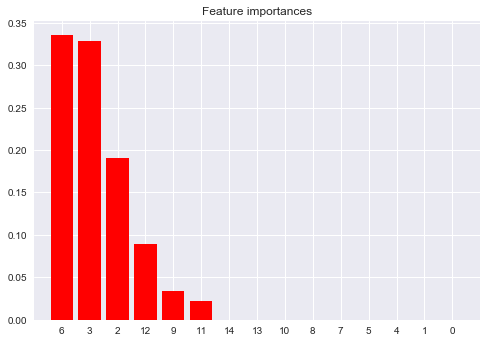

Features sorted by their score:
[(0.3355, 'Pclass_Business'), (0.328, 'distance_seg'), (0.1909, 'advance_purchase'), (0.0888, 'Channel_Electronic'), (0.0345, 'Pclass_Economy'), (0.0223, 'Channel_Airline'), (0.0, 'fqtv_data'), (0.0, 'age'), (0.0, 'Sex_M'), (0.0, 'Sex_F'), (0.0, 'Pclass_Premium'), (0.0, 'Flight_I'), (0.0, 'Flight_D'), (0.0, 'Channel_Travel_Agency'), (0.0, 'Channel_No-Iata')]


In [44]:
importances = ctr.feature_importances_
names = variables.columns
std = np.std([ctr.feature_importances_ for tree in names],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), importances), names), 
             reverse=True)

#### We can export the tree using the export_graphviz exporter. Graphviz format also supports a variety of aesthetic options, including coloring nodes by their class (or value for regression) and using explicit variable and class names if desired. We render the plot of decsion tree inline using the Image() function:


In [45]:
from sklearn import tree

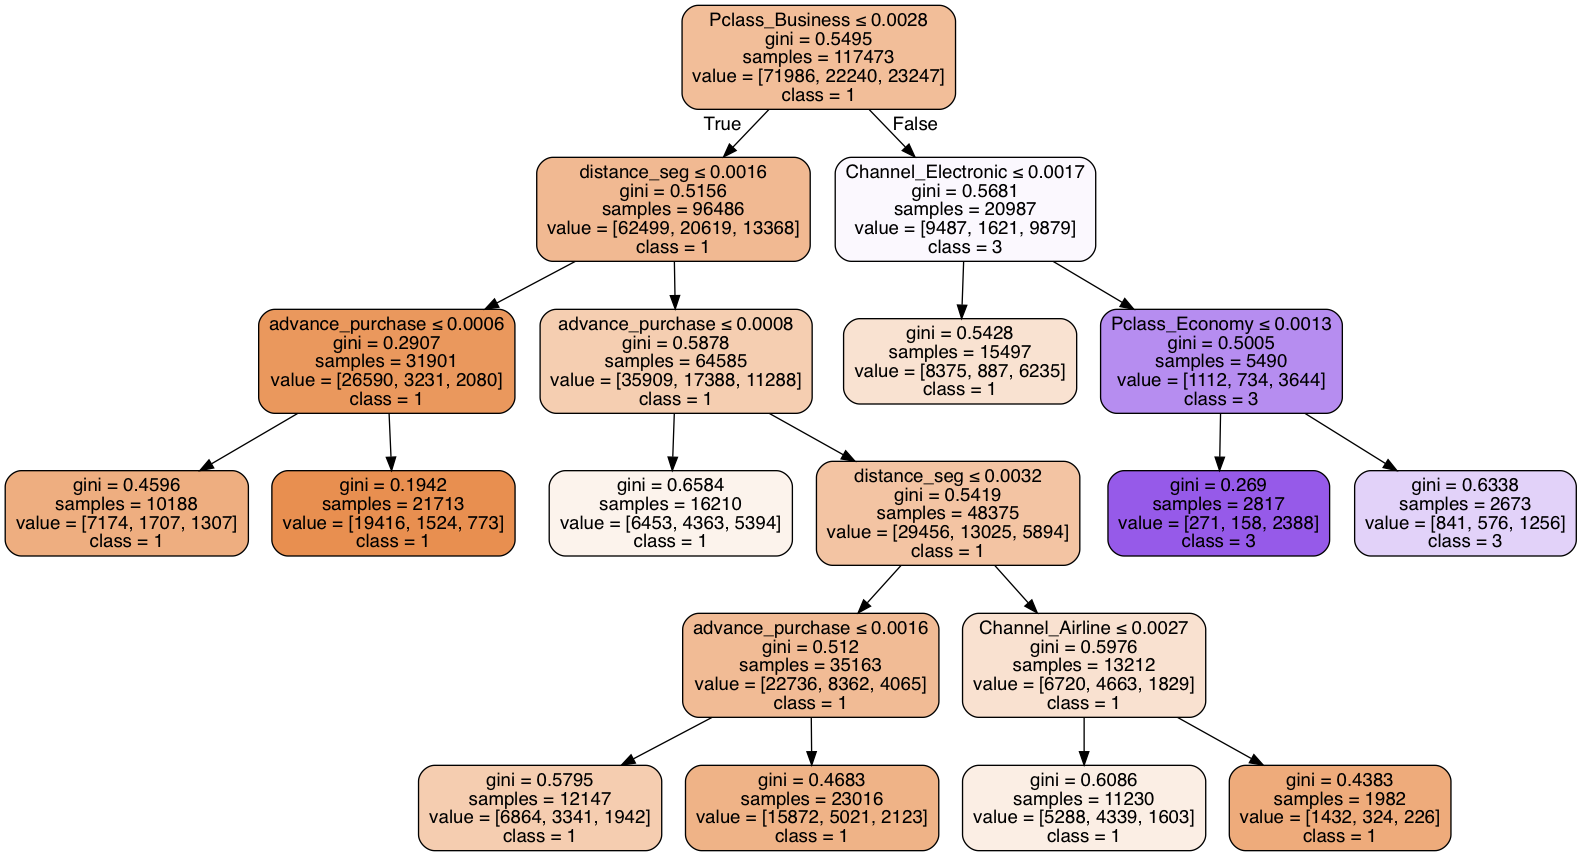

In [46]:
from IPython.display import Image  
dot_data = StringIO()  
tree.export_graphviz(ctr, out_file=dot_data,  
                         feature_names= variables.columns,  
                         class_names= ctr_.classes_.astype(int).astype(str),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

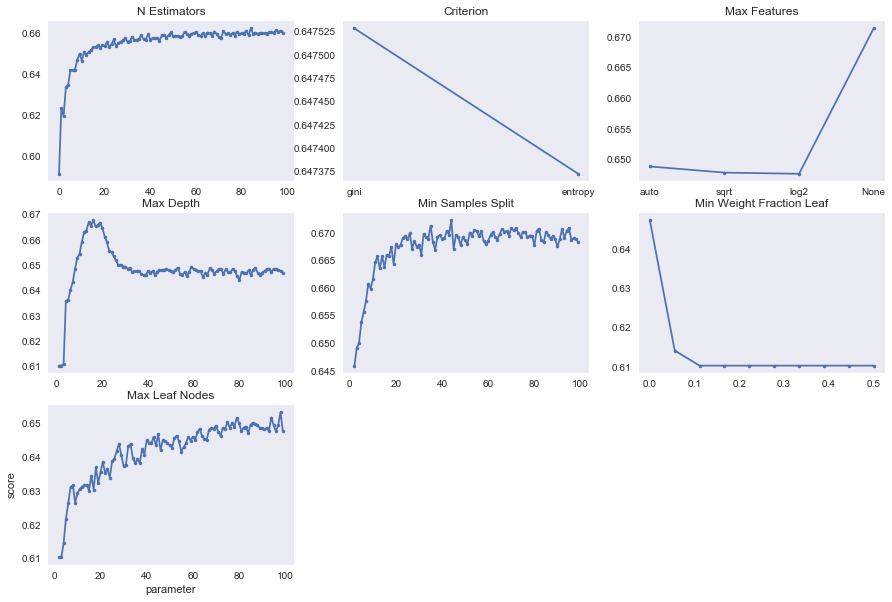

In [58]:
plt.figure(figsize=(15,10))

#N Estimators
plt.subplot(3,3,1)
feature_param = range(1,100)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('N Estimators')
plt.grid();

#Criterion
plt.subplot(3,3,2)
feature_param = ['gini','entropy']
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(criterion=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('Criterion')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Features
plt.subplot(3,3,3)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(3,3,4)
feature_param = range(1,100)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(3,3,5)
feature_param = range(2,100)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,100)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();

### After analyzing the different graphics, we select the values to each model parameter

In [109]:
clf = RandomForestClassifier(n_estimators=100, 
                             criterion='gini', 
                             max_depth=18, 
                             min_samples_split=8, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.03, 
                             max_features='log2', 
                             max_leaf_nodes=10, 
                             class_weight=None)

### We examine the accuracy of random forest model with the confusion matrix


[[ 0.99869744  0.          0.00130256]
 [ 0.99684741  0.          0.00315259]
 [ 0.95988814  0.          0.04011186]]


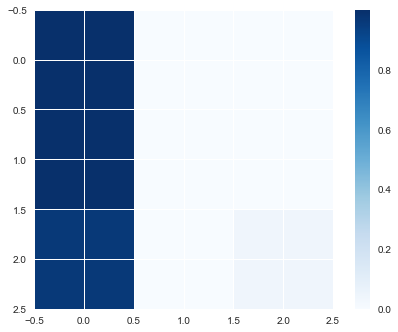

In [110]:
from sklearn.metrics import confusion_matrix
clf = clf.fit(X_train, y_train)
predictarr = clf.predict(X_test)
trutharr = y_test.values
cm = confusion_matrix(trutharr, predictarr)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

confusion = np.matrix(cm_normalized)
print (cm_normalized)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

Feature ranking:
1. feature 3 (0.344006)
2. feature 6 (0.231156)
3. feature 2 (0.131503)
4. feature 9 (0.084247)
5. feature 12 (0.057922)
6. feature 14 (0.055684)
7. feature 4 (0.029523)
8. feature 5 (0.020136)
9. feature 11 (0.017217)
10. feature 0 (0.015611)
11. feature 13 (0.002996)
12. feature 10 (0.000000)
13. feature 8 (0.000000)
14. feature 7 (0.000000)
15. feature 1 (0.000000)


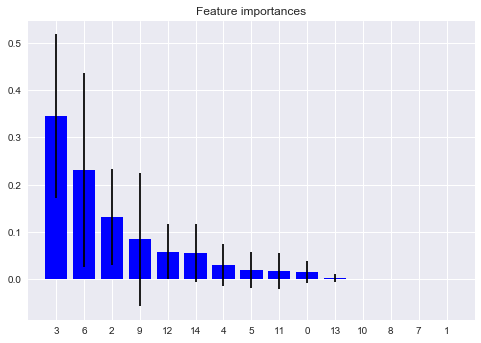

Features sorted by their score:
[(0.344, 'distance_seg'), (0.2312, 'Pclass_Business'), (0.1315, 'advance_purchase'), (0.0842, 'Pclass_Economy'), (0.0579, 'Channel_Electronic'), (0.0557, 'Channel_Travel_Agency'), (0.0295, 'Sex_F'), (0.0201, 'Sex_M'), (0.0172, 'Channel_Airline'), (0.0156, 'age'), (0.003, 'Channel_No-Iata'), (0.0, 'fqtv_data'), (0.0, 'Pclass_Premium'), (0.0, 'Flight_I'), (0.0, 'Flight_D')]


In [111]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
names = variables.columns
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), importances), names), reverse=True)